In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from bayes import logPr_bayes, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()

In [2]:
def logPr_bayes(logL, likelihood, mean, covinv, theta):
    """likelihood = f(X_i, theta)"""
    Xstar = likelihood.inverse(logL, theta)
    log_abs_fprimes = np.log(abs(likelihood.prime(Xstar, theta)))
    return - np.sum(log_abs_fprimes) - 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean)

def simple_like():
    def func(X, d):
        return -X**(2/d)
    def inverse(logL, d):
        return (-logL)**(d/2)
    def prime(X, d):
        return - (2/d) * X**(2/d - 1)
    return likelihood(func, inverse, prime)
simple = simple_like()

def middle_like():
    def func(X, theta):
        d, sigma = theta
        return - X**(2/d)/(2*sigma**2)
    def inverse(logL, theta):
        d, sigma = theta
        return (-2*sigma**2*logL)**(d/2)
    def prime(X, theta):
        d, sigma = theta
        return - (1/d*sigma**2) * X**(2/d - 1)
    return likelihood(func, inverse, prime)
middle = middle_like()

In [3]:
def logPr_laplace(theta, logpr_max, theta_max, Hessian):
    if len(theta) == 1:
        return float(logpr_max - 1/2 * (theta - theta_max).T * (- Hessian) * (theta - theta_max))
    return logpr_max - 1/2 * (theta - theta_max).T @ (- Hessian) @ (theta - theta_max) # A = negative hessian


def logPr_laplace_bayes(logL, likelihood, mean, covinv, theta_max, theta):
    logprmax = logPr_bayes(logL, likelihood, mean, covinv, theta_max)

In [55]:
nk = 500 * np.ones(200)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
cov_X = X_Sigma(nk)
theta_true = 10
X = generate_Xs(nk)
y = simple.func(X, theta_true)

### **1D case**

In [61]:
theta_true = 10
X = generate_Xs(nk)
y = simple.func(X, theta_true)

# Hessian
from autograd import grad
thetas = np.linspace(8, 12, 50)
def logPr_bayes_ag(theta):
    return logPr_bayes(y, simple, mean_X, covinv_X, theta)
hess_logPr = grad(grad(logPr_bayes_ag))

theta_b = minimise_bayes(y, simple, mean_X, covinv_X, theta_true).x
hess = hess_logPr(theta_b)
hess

array([-4.61999484])

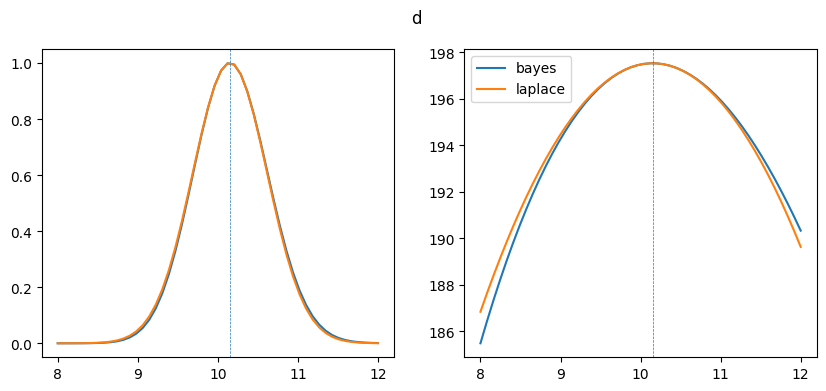

In [68]:
prs_bayes = np.zeros_like(thetas)
prs_laplace = np.zeros_like(thetas)
theta_b = minimise_bayes(y, simple, mean_X, covinv_X, theta_true).x
logprmax = logPr_bayes(y, simple, mean_X, covinv_X, theta_b)
hess = hess_logPr(theta_b)

for i, theta in enumerate(thetas):
    prs_bayes[i] = logPr_bayes(y, simple, mean_X, covinv_X, theta)
    prs_laplace[i] = logPr_laplace(np.array([theta]), logprmax, theta_b, hess)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(thetas, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
ax1.plot(thetas, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
ax1.axvline(x=theta_b, ls='--', lw=.5)
ax2.plot(thetas, prs_bayes, label='bayes')
ax2.plot(thetas, prs_laplace, label='laplace')
ax2.axvline(x=theta_b, ls='--', lw=.5)
plt.suptitle('d')
plt.legend();

In [9]:
hess

array([-4.41522635])

### **2D case**

In [15]:
def h(x,t):
    return np.dot(x,t) + np.exp(np.dot(x,t))
h_x = grad(h, 0) # derivative with respect to x
h_t = grad(h,1) # derivative with respect to t

In [27]:
theta_true = [10, 0.1]
X = generate_Xs(nk)
y = middle.func(X, theta_true)